In [2]:
%load_ext autoreload
%autoreload 2
#new testing
import glob
from fibsem.segmentation.model import SegmentationModel
import tifffile as tf
import matplotlib.pyplot as plt


from random import shuffle

import numpy as np 
# from autoscript_sdb_microscope_client.structures import AdornedImage

from fibsem.structures import Point
from fibsem.imaging import masks
from fibsem.detection.detection import NeedleTip, LamellaCentre, locate_shift_between_features_v2, plot_det_result_v2
import skimage

from pathlib import Path
from dataclasses import dataclass

from fibsem import conversions


from pprint import pprint


from fibsem.segmentation.model import load_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Detection Goals


1. Detect Needle Tip
2. Detect Lamella Centre
3. Detect Lamella Edges (Right / Left, Up / Down)

account for multiple lamellas
mask centre?

In [10]:
labels = []
p1_type = []
p2_type = []
p1_x = []
p1_y = []
p2_x = []
p2_y = []

64


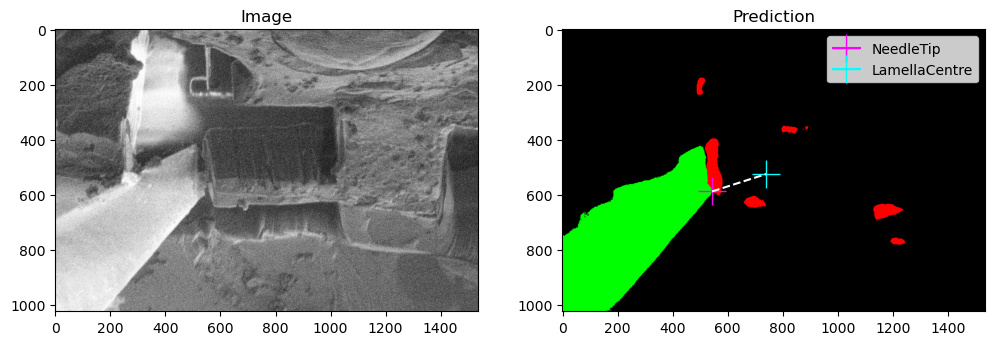

Feature: NeedleTip:  x: 543, y: 588
Feature: LamellaCentre:  x: 739, y: 525


In [16]:


# data

from fibsem import config



# filenames = glob.glob(r"C:\Users\Admin\Github\fibsem\fibsem\segmentation\data\train\images/*.tif")
filenames = glob.glob(r"C:\Users\Rohit\Documents\UNI\DEMARCO\new_eval\label_00\*.tif")
assert len(filenames) > 0
print(len(filenames))

# model
checkpoint = r"C:\Users\Rohit\Documents\UNI\DEMARCO\seg_model_fibsem\model4.pt"
model = load_model(checkpoint,encoder="resnet34")




def to_bounding_box(contour):
    # convert a contour to bounding box (xc, yc, w, h)
    # ref : https://muthu.co/draw-bounding-box-around-contours-skimage/

    xmin, xmax = np.min(contour[:, 1]), np.max(contour[:, 1])
    ymin, ymax = np.min(contour[:, 0]), np.max(contour[:, 0])

    w = (xmax - xmin)
    h = (ymax - ymin)
    xc = xmin + w // 2
    yc = ymin + h // 2
    
    return [xc, yc, w, h]
    
# THINGS TO TRY:
# masking centre area for lamella
# using contours to extract individual lamellas -> pick centre



for i, fname in enumerate(filenames):

    img = tf.imread(fname)

    # inference
    mask = model.inference(img)

    # detect features
    features = [NeedleTip(), LamellaCentre()]

    det = locate_shift_between_features_v2(img, model, features=features, pixelsize=10e-9)
    label = name = fname.split('\\')[-1][:-4]
    labels.append(label)
    # plot
    plot_det_result_v2(det)
    base_file_path = r"C:\Users\rkan0039\Documents\detection_training\evaluation\_{}f"
   
    #plot_det_result_EVAL(det,save=True,save_path=save_path)
    f1 = det.features[0]
    f2 = det.features[1]

    p1_type.append(f1.name)
    p2_type.append(f2.name)
    p1_x.append(f1.feature_px.x)
    p1_y.append(f1.feature_px.y)
    p2_x.append(f2.feature_px.x)
    p2_y.append(f2.feature_px.y)

    print(f"Feature: {f1.name}:  x: {f1.feature_px.x}, y: {f1.feature_px.y}")
    print(f"Feature: {f2.name}:  x: {f2.feature_px.x}, y: {f2.feature_px.y}")

    data = {"label":labels,"p1_type":p1_type,"p1_x":p1_x,"p1_y":p1_y,"p2_type":p2_type,"p2_x":p2_x,"p2_y":p2_y}

    if i == 0:
        break


In [ ]:
import pandas as pd

df = pd.DataFrame(data)

df.to_csv(r"C:\Users\Rohit\Documents\UNI\DEMARCO\new_eval\label_00\ML_output.csv")

In [19]:
print(p1_x)

[543, 543]


In [ ]:


# mask helper


# centre circle
# left/right half
# top/bottom half


from fibsem.imaging import masks
import numpy as np


arr = np.zeros(shape=(720, 1200 ))

circ_mask = masks.create_circle_mask(arr.shape, radius=128)

bl_mask = masks.create_area_mask(arr, left=True, lower=True)
ul_mask = masks.create_area_mask(arr, left=True, upper=True)
br_mask = masks.create_area_mask(arr, left=True, lower=True)
ur_mask = masks.create_area_mask(arr, right=True, upper=True)
mask = masks.create_area_mask(arr, left=True)


fig, ax = plt.subplots(1, 5, figsize=(15, 7))
ax[0].imshow(bl_mask)
ax[1].imshow(ul_mask)
ax[2].imshow(br_mask)
ax[3].imshow(ur_mask)
ax[4].imshow(mask)
plt.show()



In [ ]:
# contour stuff
    # options for getting individual lamella from multiple: contours, masking 
    # bboxes = []
    # contours = skimage.measure.find_contours(lamella_mask[:, :, 0].astype(np.uint8), 0.8)
    # for contour in contours:
    #     bboxes.append(to_bounding_box(contour))
        # for contour in contours:
    #     ax[1].plot(contour[:, 1], contour[:, 0], color="white", linewidth=1)
    

In [ ]:
## vertical mask for eucentric correction

# autoreload 2
%load_ext autoreload
%autoreload 2

from fibsem.imaging import masks
import numpy as np
import matplotlib.pyplot as plt

# mask only the central vertical area
arr = np.zeros(shape=(1024, 1536 ))

mask = masks.create_vertical_mask(arr)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.imshow(mask)
plt.show()

